In [105]:
import tensorflow as tf
from tensorflow import keras
import os
import warnings
from pathlib import Path
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

## Dataset Splitting into Train, Validation, and Test Folders

In [3]:
import splitfolders

# Split dataset into train, val, and test
splitfolders.ratio(
    "/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Converted_Dataset",  # Input folder containing subfolders for each class
    output="/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Split_data",  # Output folder for train, val, and test splits
    seed=42,
    ratio=(0.7, 0.2, 0.1)  # Train: 70%, Val: 20%, Test: 10%
)


Copying files: 500 files [00:00, 1405.89 files/s]


## Reading data with ImageDataGenerator

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training generator (only rescaling, no augmentation)
train_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Validation and Test generators (same as training, no shuffle for validation and test)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load training data
train_ds = train_datagen.flow_from_directory(
    '/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Split_data/train',
    target_size=(150, 150),  # Adjust to match your model's input size
    batch_size=32,
    class_mode="categorical",
    shuffle=True,  # Shuffle for training
    seed=42
)

# Load validation data
val_ds = val_test_datagen.flow_from_directory(
    '/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Split_data/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,  # No shuffle for validation
    seed=42
)

Found 350 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


## Base Model Architecture using Transfer Learning - Xception model

In [13]:
# Define the input shape
input_shape = (150, 150, 3)

# Create the base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
base_model.trainable = False

# Define the custom model architecture
inputs = Input(shape=input_shape)  # Input layer
base = base_model(inputs, training=False)  # Pass inputs through the base model
global_pool = GlobalAveragePooling2D()(base)  # Global Average Pooling layer
outputs = Dense(5, activation='softmax')(global_pool)  # Output layer (5 classes for grapevine species)

# Create the model
model = Model(inputs, outputs)

# Compile the model
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
loss = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [15]:
# Train the model (example placeholder code, replace train_ds and val_ds with actual datasets)
history = model.fit(
    train_ds,  # Training dataset
    epochs=10,  # Number of epochs
    validation_data=val_ds  # Validation dataset
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 582ms/step - accuracy: 0.3308 - loss: 1.7993 - val_accuracy: 0.5100 - val_loss: 1.2876
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 543ms/step - accuracy: 0.6846 - loss: 0.8934 - val_accuracy: 0.5100 - val_loss: 1.0620
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 523ms/step - accuracy: 0.7881 - loss: 0.6339 - val_accuracy: 0.6200 - val_loss: 0.9821
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 534ms/step - accuracy: 0.8718 - loss: 0.4840 - val_accuracy: 0.5700 - val_loss: 1.0914
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 528ms/step - accuracy: 0.8829 - loss: 0.4066 - val_accuracy: 0.6600 - val_loss: 0.9868
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 526ms/step - accuracy: 0.9115 - loss: 0.3338 - val_accuracy: 0.6200 - val_loss: 1.0933
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 533ms/step - accuracy: 0.9399 - loss: 0.2967 - val_accuracy: 0.7000 - val_loss: 1.0055
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 524ms/step - accuracy: 0.9750 - loss: 0.2207 - val_accuracy: 0.

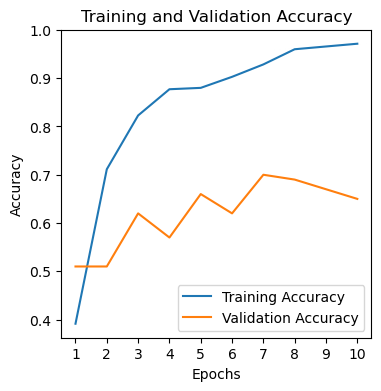

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the training and validation accuracy
plt.figure(figsize=(4, 4))  # Set figure size for better readability
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xticks(np.arange(len(history.history['accuracy'])), labels=np.arange(1, len(history.history['accuracy']) + 1))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')  # Position the legend
plt.show()


## Model Architecture for Learning Rate Tuning

In [27]:
# function to create model with learning rate as paramenter
def create_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )
    
    base_model.trainable = False
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(5)(vectors)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
      
    return model

## Hyperparameter Tuning: Learning Rate

In [29]:
# initializing a dictionary to keep the histories against each learning rate
scores = {}
# running to check best learning_rate
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print('learning rate choosen is ', lr)

    model = create_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

learning rate choosen is  0.0001
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 595ms/step - accuracy: 0.1563 - loss: 1.7122 - val_accuracy: 0.1400 - val_loss: 1.6769
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 534ms/step - accuracy: 0.1719 - loss: 1.6483 - val_accuracy: 0.1600 - val_loss: 1.6429
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 533ms/step - accuracy: 0.2494 - loss: 1.5811 - val_accuracy: 0.2000 - val_loss: 1.6133
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 537ms/step - accuracy: 0.2452 - loss: 1.5551 - val_accuracy: 0.2400 - val_loss: 1.5884
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 546ms/step - accuracy: 0.3137 - loss: 1.5198 - val_accuracy: 0.2600 - val_loss: 1.5651
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 539ms/step - accuracy: 0.3494 - loss: 1.4992 - val_accuracy: 0.3000 - val_loss: 1.5452
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 539ms/step - accuracy: 0.3933 - loss: 1.4573 - val_accuracy: 0.3100 - val_loss: 1.5254
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 529ms/step - accuracy: 0.4590 

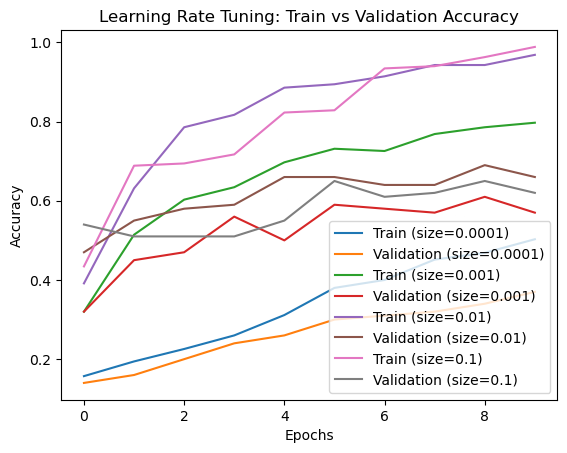

In [31]:
for size, hist in scores.items():
    plt.plot(hist['accuracy'], label=f"Train (size={size})")
    plt.plot(hist['val_accuracy'], label=f"Validation (size={size})")

plt.title("Learning Rate Tuning: Train vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


The learning rate 0.01 was selected as it demonstrated faster convergence during training and achieved the highest validation accuracy, indicating better generalization to unseen data.

## Model Architecture for Inner Dense Layer Size Tuning

In [37]:
# function to create model with extra inner layer
def create_model_with_extra_layer(learning_rate, size_inner):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    #add the extra inner layer
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(5)(inner)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model


## Hyperparameter Tuning: Inner Dense Layer Size

In [45]:
# initializing a dictionary to keep the histories against each learning rate
scores_extra_layer = {}
# running to check best accuracy scores with various sizes of the extra
for size in [64, 128, 256, 512]:
    print('size of the extra inner layer ', size)

    model = create_model_with_extra_layer(learning_rate, size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores_extra_layer[size] = history.history

    print()
    print()

size of the extra inner layer  64
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 577ms/step - accuracy: 0.3381 - loss: 1.9332 - val_accuracy: 0.4900 - val_loss: 1.5445
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 533ms/step - accuracy: 0.6248 - loss: 1.0128 - val_accuracy: 0.5400 - val_loss: 1.0661
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 535ms/step - accuracy: 0.7788 - loss: 0.6902 - val_accuracy: 0.5400 - val_loss: 1.1033
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step - accuracy: 0.8263 - loss: 0.4501 - val_accuracy: 0.6300 - val_loss: 1.0095
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 536ms/step - accuracy: 0.8596 - loss: 0.3628 - val_accuracy: 0.6100 - val_loss: 1.2844
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 527ms/step - accuracy: 0.9159 - loss: 0.3108 - val_accuracy: 0.7100 - val_loss: 1.0586
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 531ms/step - accuracy: 0.9266 - loss: 0.2657 - val_accuracy: 0.7200 - val_loss: 1.0898
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 535ms/step - accuracy: 0.9631

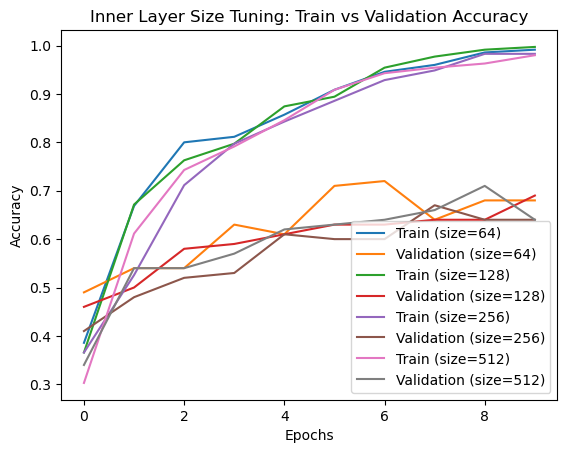

In [47]:
for size, hist in scores_extra_layer.items():
    plt.plot(hist['accuracy'], label=f"Train (size={size})")
    plt.plot(hist['val_accuracy'], label=f"Validation (size={size})")

plt.title("Inner Layer Size Tuning: Train vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Inner Layer Size = 128 provides better generalization, balancing training and validation accuracy

In [49]:
#set the best selected parameters
learning_rate = 0.01
size = 128

## Model Architecture for Dropout Rate Tuning

In [51]:
# function to create model with dropout rate

def create_model_with_dropout(learning_rate, size_inner, droprate):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    # setting dropout for the model training with droprate to the inner layer
   
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(5)(drop)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

## Hyperparameter Tuning: Dropout rate

In [53]:
# training the model with different dropout rates
scores_dropout = {}

for droprate in [0.2, 0.5, 0.8]:
    print('dropout rate is ', droprate)

    model = create_model_with_dropout(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=20, validation_data=val_ds)
    scores_dropout[droprate] = history.history

    print()


dropout rate is  0.2
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 600ms/step - accuracy: 0.2180 - loss: 2.9751 - val_accuracy: 0.4700 - val_loss: 1.5775
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step - accuracy: 0.5445 - loss: 1.1544 - val_accuracy: 0.4800 - val_loss: 1.2449
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 538ms/step - accuracy: 0.6850 - loss: 0.8384 - val_accuracy: 0.5400 - val_loss: 1.1622
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 524ms/step - accuracy: 0.7458 - loss: 0.7397 - val_accuracy: 0.5300 - val_loss: 1.1024
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 523ms/step - accuracy: 0.8733 - loss: 0.5044 - val_accuracy: 0.5800 - val_loss: 1.1200
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 545ms/step - accuracy: 0.8244 - loss: 0.4626 - val_accuracy: 0.6500 - val_loss: 1.0283
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 538ms/step - accuracy: 0.8623 - loss: 0.3783 - val_accuracy: 0.6100 - val_loss: 1.0444
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 536ms/step - accuracy: 0.9132 - loss: 0.29

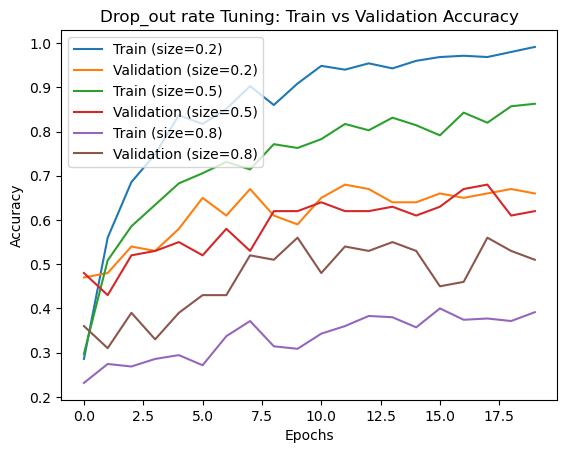

In [55]:
for size, hist in scores_dropout.items():
    plt.plot(hist['accuracy'], label=f"Train (size={size})")
    plt.plot(hist['val_accuracy'], label=f"Validation (size={size})")

plt.title("Drop_out rate Tuning: Train vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Dropout Rate 0.2 is the best choice as it achieves better validation accuracy and generalization.

In [57]:
#set the best selected parameters
learning_rate = 0.01
size = 128
droprate = 0.2

## Model Architecture for Larger Model Training with Best Evaluated Hyperparameters

In [81]:
# create the model architechture for the larger model with best parameters

#for larger model
input_size = 299

def final_model(input_size, learning_rate, size_inner, droprate):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(5)(drop)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [83]:
# Load training data
train_ds = train_datagen.flow_from_directory(
    '/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Split_data/train',
    target_size=(299, 299),  # Adjust to match your model's input size
    batch_size=32,
    class_mode="categorical",
    shuffle=True,  # Shuffle for training
    seed=42
)

# Load validation data
val_ds = val_test_datagen.flow_from_directory(
    '/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Split_data/val',
    target_size=(299, 299),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,  # No shuffle for validation
    seed=42
)

Found 350 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


## Model Checkpointing

In [94]:
# checkpointing to save the best model
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v_final_{epoch:02d}_{val_accuracy:.2f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)


# training the larger model
print('learning_rate is ', learning_rate)
print('size is ', size)
print('droprate is ', droprate)
print()
print()

model1 = final_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

#suppress warnings
warnings.filterwarnings('ignore', category=UserWarning, message=".*HDF5.*")

history = model1.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

learning_rate is  0.01
size is  128
droprate is  0.2


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.2628 - loss: 2.5520 - val_accuracy: 0.5200 - val_loss: 1.1869
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5882 - loss: 1.1615 - val_accuracy: 0.7600 - val_loss: 0.8525
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7191 - loss: 0.7707 - val_accuracy: 0.7800 - val_loss: 0.7421
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7508 - loss: 0.6384 - val_accuracy: 0.6900 - val_loss: 0.8588
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7816 - loss: 0.5493 - val_accuracy: 0.7600 - val_loss: 0.6521
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8560 - loss: 0.4293 - val_accuracy: 0.7500 - val_loss: 0.6062
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8626 - loss: 0.3821 - val_accuracy: 0.7900 - val_loss: 0.5743
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0

## Using the Model on Test Data

In [98]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the test generator
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    '/Users/sindhujaarivukkarasu/Documents/ML Zoomcamp-Capstone-2/Split_data/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,  # No shuffle for validation
    seed=42
)

Found 50 images belonging to 5 classes.


In [100]:
# loading the model
model = keras.models.load_model('xception_v_final_35_0.88.keras')

In [102]:
model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 956ms/step - accuracy: 0.9287 - loss: 0.5916


[0.5017759203910828, 0.9399999976158142]

The final model shows a high accuracy of 0.92 when evaluated on the unseen test data

In [126]:
from tensorflow.keras.models import load_model
import pickle
# Load the model
final_model = load_model('xception_v_final_35_0.88.keras')



Model saved as 'grapevine_xception_model.pkl'
